# Table of contents
1. [Introduction](#introduction) 
2. [Packages, functions, classes](#packages-classes)
3. [Data](#data)
    1. [Prepare, visualize data](#prepare-data)
    2. [Preprocess data](#preprocess-data)
3. [데이터 준비하기 및 전처리](#preparation)


### Sub paragraph <a name="subparagraph1"></a>
This is a sub paragraph, formatted in heading 3 style

## Another paragraph <a name="paragraph2"></a>
The second paragraph text

In [1]:
# !mkdir -p ~/aiffel/chest_xray

In [2]:
# !ln -s ~/data/ ~/aiffel/chest_xray

# Introduction <a name="introduction"></a> 

##  Pneumonia classification model    <br>
> Given normal and pnemonia x-ray images, classify the image with pneumonia <br> 

Step 1. 실험환경 Set-up
거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

Step 2. 데이터 준비하기
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다. 그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

# Packages and functions<a name="packages-classes"></a>

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Image data generator 
warnings.filterwarnings(action='ignore')

In [67]:
from tensorflow import keras 
from tensorflow.keras import layers

In [2]:
# Set the figure size
plt.figure(figsize=(20, 6))

# Set the font size
plt.rcParams['font.size'] = 14

# Set the colors
colors = ['lightgreen', 'lightblue']

<Figure size 1440x432 with 0 Axes>

In [3]:
## site: https://www.kaggle.com/code/amirtarek74/chest-ct-scan-classification-90-test-acc
#trainGenertor = ImageDataGenerator(
#    preprocessing_function = preprocess_input,
#    rotation_range = 10,
#    width_shift_range = 0.3,
#    height_shift_range = 0.3,
#    shear_range = 0.2,
#    zoom_range = 0.1,
#    horizontal_flip = True,
#    vertical_flip = True,
#    dtype = 'float32'
#)
#valGenertor = ImageDataGenerator(
#    preprocessing_function = preprocess_input,
#    dtype = 'float32'
#)
#
#testGenertor = ImageDataGenerator(
#    preprocessing_function = preprocess_input,
#    dtype = 'float32'
#)

In [4]:
# in AIFFEL
#def augment(image,label):
#    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#    return image,label
#
#def prepare_for_training(ds, shuffle_buffer_size=1000):
#    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#    ds = ds.map(
#            augment,       # augment 함수 적용
#            num_parallel_calls=2
#        )
#    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#    ds = ds.repeat()
#    ds = ds.batch(BATCH_SIZE)
#    ds = ds.prefetch(buffer_size=AUTOTUNE)
#
#    return ds
#
##train_ds = prepare_for_training(train_ds)
##val_ds = prepare_for_training(val_ds)

# Data

In [5]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [6]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [7]:
train_filenames[:3]

['/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0487-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0987-0001.jpeg',
 '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0700-0001.jpeg']

In [8]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [9]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [10]:
def conditional_count_filenames(li: list, condition):
    """
    Here, there are cases (two cases here)
    Function that counts filenames based on the condition specified in the path,
    one level above the filename.
    """
    pass

In [11]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [12]:
COUNT_NORMAL_VAL = len([filename for filename in val_filenames if "NORMAL" in filename])
print(f"Normal images count in validation set: {COUNT_NORMAL_VAL}")


COUNT_PNEUMONIA_VAL = len([filename for filename in val_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in validation set: {COUNT_PNEUMONIA_VAL}")

Normal images count in validation set: 279
Pneumonia images count in validation set: 768


In [13]:
COUNT_NORMAL_TEST = len([filename for filename in test_filenames if "NORMAL" in filename])
print(f"Normal images count in test set: {COUNT_NORMAL_TEST}")


COUNT_PNEUMONIA_TEST = len([filename for filename in test_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in test set: {COUNT_PNEUMONIA_TEST}")

Normal images count in test set: 234
Pneumonia images count in test set: 390


## Data visualization
Pie chart visualization

In [14]:
def draw_pie(li: list, datatype:str):
    plt.pie(li, labels = ['Normal', 'Pnuemonia'], autopct='%1.1f%%', colors=colors)
    plt.title(datatype)

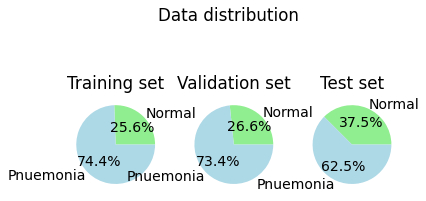

In [15]:
plt.subplot(1, 3, 1)
draw_pie([COUNT_NORMAL, COUNT_PNEUMONIA], 'Training set')
plt.subplot(1, 3, 2)
draw_pie([COUNT_NORMAL_VAL, COUNT_PNEUMONIA_VAL], 'Validation set')
plt.subplot(1, 3, 3)
draw_pie([COUNT_NORMAL_TEST, COUNT_PNEUMONIA_TEST], 'Test set')
plt.suptitle('Data distribution')
plt.show()

In [16]:
# Function to apply Ben Graham's method on 5 random images from a class
def visualize_images_ben_graham(dataset, title):
    plt.figure(figsize=(15,10))
    for i in range(5):
        # Choose a random image from the dataset
        random_image_path = random.choice(dataset)
        
        # Load the image
        img = cv2.imread(random_image_path)
        
        # Resize the image
        img = cv2.resize(img, (512, 512))
        
        # Convert the image to HSV
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        # Apply Ben Graham's method
        img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
        
        # Display the image
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
    plt.show()

In [17]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [18]:
next(train_list_ds.batch(60_000).as_numpy_iterator())[2]

b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person426_bacteria_1863.jpeg'

In [19]:
next(train_list_ds.batch(60_000).as_numpy_iterator())[1]

b'/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1026_bacteria_2957.jpeg'

In [20]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [21]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [22]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [48]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [49]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.ParallelMapDataset

In [50]:
# how to use that dataset
for i in train_ds.take(1):
    print(i)

(<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[0.3816679 , 0.3816679 , 0.3816679 ],
        [0.10745463, 0.10745463, 0.10745463],
        [0.09698012, 0.09698012, 0.09698012],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.23363836, 0.23363836, 0.23363836],
        [0.11332245, 0.11332245, 0.11332245],
        [0.11621279, 0.11621279, 0.11621279],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.14335029, 0.14335029, 0.14335029],
        [0.12213509, 0.12213509, 0.12213509],
        [0.12215567, 0.12215567, 0.12215567],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0. 

In [51]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [52]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [28]:
# Augment data
datagen = ImageDataGenerator(
    rotation_range=20, # Randomly rotate the image between 0 and 20 degrees
    width_shift_range=0.1, # Randomly shift the image horizontally by up to 10% of its width
    height_shift_range=0.1, # Randomly shift the image vertically by up to 10% of its height
    shear_range=0.1, # Randomly apply shearing transformations
    zoom_range=0.1, # Randomly zoom in on the image by up to 10%
    horizontal_flip=True, # Randomly flip the image horizontally
    fill_mode='nearest' # Fill any empty pixels with the nearest pixel value
)

augmented_data = []
for example in train_ds.as_numpy_iterator():
    image = example[0]
    label = example[1]
    if label == False:
        augmented_images = datagen.flow(
        x= image.reshape(1, *image.shape),
        batch_size = 1,
        shuffle = False
        )
        augmented_image = next(augmented_images)[0]
        augmented_data.append((augmented_image, label))
    else:
        augmented_data.append((image, label))

augmented_dataset = tf.data.Dataset.from_generator(
    lambda: augmented_data,
    output_signature=(
        tf.TensorSpec(shape=augmented_data[0][0].shape, dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
    )
augmented_dataset = augmented_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
augmented_dataset

<PrefetchDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.int32)>

In [30]:
AUGMENT_MODE = True

In [53]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [55]:
train_ds = prepare_for_training(train_ds)

In [56]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

In [43]:
if AUGMENT_MODE:
    train_ds_augmented = prepare_for_training(augmented_dataset) #training augmented
else:
    train_ds = prepare_for_training(train_ds) # not augmented

In [57]:
val_ds = prepare_for_training(val_ds) # validation not run augmentation 

In [58]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch, is_augmented):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if is_augmented:
            plt.suptitle('Augmented against Normal only')
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

In [59]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

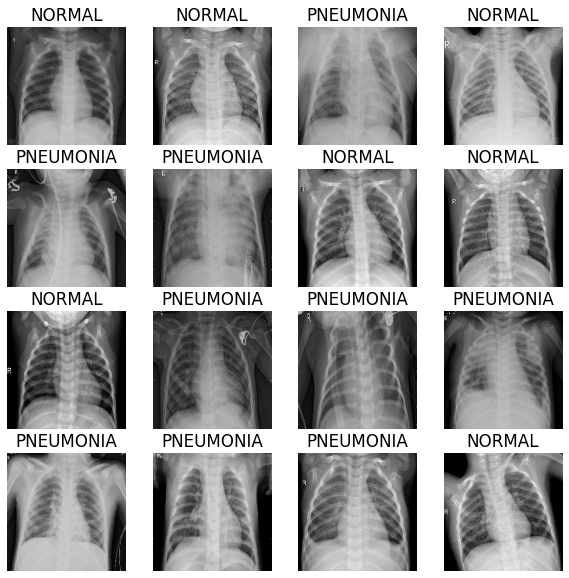

In [60]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy(), is_augmented = False)

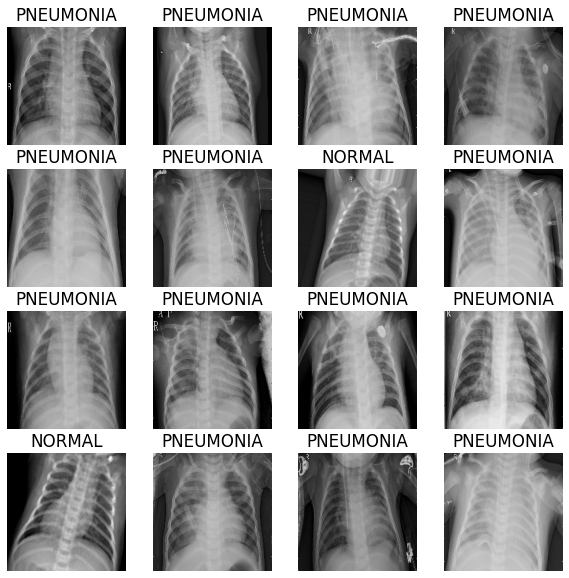

In [61]:
image_batch, label_batch = next(iter(train_ds_augmented))
show_batch(image_batch.numpy(), label_batch.numpy(), is_augmented = True)

> How should we know that data are augmented right?

# Model

## Resnet 
- with and without Resnet

In [89]:
from keras.models import Model
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add

In [113]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = AveragePooling2D(pool_size = (7,7))
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [114]:
model = ResNet18(num_classes = 3)

In [115]:
# weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [116]:
with tf.device('/GPU:0'):
    model.build(input_shape = (None, IMAGE_SIZE[0],IMAGE_SIZE[1],3))

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# 1-5

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 100s 206ms/step - loss: 0.3988 - accuracy: 0.7893 - precision: 0.9474 - recall: 0.7590 - val_loss: 0.6937 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 59s 227ms/step - loss: 0.2172 - accuracy: 0.9159 - precision: 0.9739 - recall: 0.9116 - val_loss: 1.2413 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 97s 372ms/step - loss: 0.2003 - accuracy: 0.9219 - precision: 0.9764 - recall: 0.9173 - val_loss: 0.6629 - val_accuracy: 0.7481 - val_precision: 0.7444 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 100s 385ms/step - loss: 0.1736 - accuracy: 0.9387 - precision: 0.9827 - recall: 0.9340 - val_loss: 0.0985 - val_accuracy: 0.9635 - val_precision: 0.9840 - val_recall: 0.9659
Epoch 5/10
261/261 [==============================] - 102s 393ms/step - loss: 0.1561 - acc

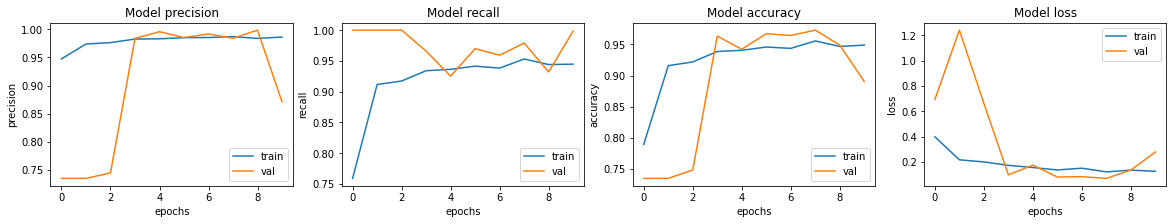

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

> `Why there are model performances, different from this kernel and AIFFEL kernel?`

![alt text](differences-model.png "Title")

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 117ms/step - loss: 1.4739 - accuracy: 0.6571 - precision: 0.6457 - recall: 1.0000
Loss: 1.4738744497299194,
Accuracy: 0.6570512652397156,
Precision: 0.6456953883171082,
Recall: 1.0
